In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor# tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # l]ayers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.utils.data import DataLoader
from torch.autograd import Variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from my_funcs import * 

In [2]:
#Load data
trainD = pd.read_csv('digit-recognizer/train.csv')
#testD = pd.read_csv('digit-recognizer/test.csv')
#sampleD = pd.read_csv('digit-recognizer/sample_submission.csv')
trainD.shape

(42000, 785)

In [3]:
y_train = trainD['label']
X_train = trainD.drop(['label'],1,inplace=False).values/255

In [4]:
torch.cuda.is_available()

True

In [5]:
from sklearn.model_selection import train_test_split
testSize = 1.0/5
featuresTrain, featuresTest, targetsTrain, targetsTest = train_test_split(X_train, y_train.values, test_size=testSize, random_state=42)
testLen = len(targetsTest)
print("The length of test data is {}".format(testLen))

device = torch.device('cuda')     # Default CUDA device

featuresTrain = torch.from_numpy(featuresTrain).type(torch.float32)
#featuresTrain = featuresTrain.to(device) #not sure if it is better memory managment to do so BEFORE the dataloader

featuresTest = torch.from_numpy(featuresTest).type(torch.float32)
#featuresTest = featuresTest.to(device)

targetsTrain = torch.from_numpy(targetsTrain).type(torch.LongTensor)
#targetsTrain = targetsTrain.to(device)

targetsTest = torch.from_numpy(targetsTest).type(torch.LongTensor)
#targetsTest = targetsTest.to(device)

featuresSize = 28*28
targetsSize = 10

# batch_size, epoch and iteration
batch_size = 280
n_iters = 10000
num_epochs = n_iters / (len(featuresTrain) / batch_size)
num_epochs = int(num_epochs)
print("The number of epochs is {}".format(num_epochs))

train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

The length of test data is 8400
The number of epochs is 83


In [6]:
#divisors = div(40768/784)
number = 8400
divisors = div(number)
prime_Divisors = pDiv(number)
print(prime_Divisors)
print(np.sort(divisors))


[[1, 2, 3, 5, 7], [1, 4, 1, 2, 1]]
[   1    2    3    4    5    6    7    8   10   12   14   15   16   20
   21   24   25   28   30   35   40   42   48   50   56   60   70   75
   80   84  100  105  112  120  140  150  168  175  200  210  240  280
  300  336  350  400  420  525  560  600  700  840 1050 1200 1400 1680
 2100 2800 4200 8400]


In [7]:
# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        # Linear part
        self.linear = nn.Linear(input_dim, output_dim)
        # There should be logistic function right?
        # However logistic function in pytorch is in loss function
        # So actually we do not forget to put it, it is only at next parts
    
    def forward(self, x):
        out = self.linear(x)
        return out
    

# create logistic regression model
model = LogisticRegressionModel(featuresSize, targetsSize)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.002
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
%%time
# Traning the Model
count = 0
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Define variables
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        # Prediction
        if count % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs
Iteration: 500  Loss: 1.5569393634796143  Accuracy: 75%
Iteration: 1000  Loss: 1.2565058469772339  Accuracy: 80%
Iteration: 1500  Loss: 0.9675431251525879  Accuracy: 82%
Iteration: 2000  Loss: 0.8557437062263489  Accuracy: 83%
Iteration: 2500  Loss: 0.7758675217628479  Accuracy: 84%
Iteration: 3000  Loss: 0.7215481400489807  Accuracy: 84%
Iteration: 3500  Loss: 0.7615463137626648  Accuracy: 85%
Iteration: 4000  Loss: 0.726697564125061  Accuracy: 85%
Iteration: 4500  Loss: 0.680799126625061  Accuracy: 85%


In [ ]:
# Create Neural Network Model
class ANN(nn.Module):
    def __init__(self, input_dim, hidden_layer, output_dim):
        super(ANN, self).__init__()
        # First Layer
        self.f1 = nn.Linear(input_dim,  hidden_layer[0])
        self.ac1 = nn.ReLU()
        # Second Layer
        self.f2 = nn.Linear(hidden_layer[0],  hidden_layer[1])
        self.ac2 = nn.Tanh()
        # Third Layer
        self.f3 = nn.Linear(hidden_layer[1],  hidden_layer[2])
        self.ac3 = nn.ELU()
        #Final Layer
        self.f4 = nn.Linear(hidden_layer[2],output_dim)
        
        
    
    def forward(self, x):
        out = self.f1(x)
        out = self.ac1(out)
        out = self.f2(out)
        out = self.ac2(out)
        out = self.f3(out)
        out = self.ac3(out)
        out = self.f4(out)
        return out
    
hidden_layer = [1000,200,100]
# create neural network model
model = ANN(featuresSize, hidden_layer, targetsSize)
#model.to(device)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
%%time
# Traning the Model
#model.to(device)
count = 0
loss_list = []
iteration_list = []
#with torch.cuda.device(0):
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

#            images = images.to(device)
#           labels = labels.to(device)
        # Define variables
        train = Variable(images.view(-1, 28*28))


        labels = Variable(labels)


        # Clear gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(train)


        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        count += 1

        # Prediction
        if count % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                #images = images.to(device)
                #labels = labels.to(device)
                test = Variable(images.view(-1, 28*28))

                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]

                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

In [ ]:
%%time
model.to(device)
with torch.cuda.device(0):
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            # Define variables
            train = Variable(images.view(-1, 28*28))
            labels = Variable(labels)


            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)
            outputs = outputs.to(device)

            # Calculate softmax and cross entropy loss
            loss = error(outputs, labels)

            # Calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            count += 1

            # Prediction
            if count % 500 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Predict test dataset
                for images, labels in test_loader: 
                    images = images.to(device)
                    labels = labels.to(device)
                    test = Variable(images.view(-1, 28*28))

                    # Forward propagation
                    outputs = model(test)
                    outputs = outputs.to(device)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    
                    # Total number of labels
                    total += len(labels)

                    # Total correct predictions
                    correct += (predicted == labels).sum()

                accuracy = 100 * correct / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

In [ ]:
# Create convolutional network Model
class conVolNN(nn.Module):
        
    def __init__(self, hidden_layer, output_dim):
        super(conVolNN, self).__init__()
        # First convolutional layer: 
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels = hidden_layer[0], kernel_size = 5, stride = 1, padding = 0)
        self.ac1 = nn.ReLU() #One image object in (N,C,H,W). (N,1,28,28) to (N,hidden_layer[0],24,24)
        self.pool1 = nn.MaxPool2d(kernel_size=2) #(N,hidden_layer[0],24,24) to (N,hidden_layer[0],12,12)
        
        # Second convolutional layer:
        self.conv2 = nn.Conv2d(in_channels= hidden_layer[0], out_channels = hidden_layer[1], kernel_size = 3, stride = 1, padding = 0)
        self.ac2 = nn.ReLU()#(N,hidden_layer[0],12,12) to (N,hidden_layer[1],10,10)
        self.pool2 = nn.MaxPool2d(kernel_size=2) #(N,hidden_layer[0],10,10) to (N,hidden_layer[0],5,5)
        
        # Third convolutional layer:
        self.conv3 = nn.Conv2d(in_channels= hidden_layer[1], out_channels = hidden_layer[2], kernel_size = 2, stride = 1, padding = 0)
        self.ac3 = nn.ReLU()#(N,hidden_layer[0],5,5) to (N,hidden_layer[1],4,4)
        self.pool3 = nn.MaxPool2d(kernel_size=2) #(N,hidden_layer[0],4,4) to (N,hidden_layer[0],2,2)
        
        #Final Layer
        self.f = nn.Linear(hidden_layer[2]*2*2,hidden_layer[3])
        self.fac = nn.Sigmoid()
        self.f1 = nn.Linear(hidden_layer[3],output_dim)
        
        
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.ac1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.ac2(out)
        out = self.pool2(out)
        out = self.conv3(out)
        out = self.ac3(out)
        out = self.pool3(out)
        out = out.view(out.size(0),-1) # Don't forget to flatten before the final linear transformation.
        out = self.f(out) #The logistic transformation is on the loss function.
        out = self.fac(out)
        out = self.f1(out) #The logistic transformation is on the loss function.
        return out
    
    
    # Create ANN
model = conVolNN([32,32,16,200],targetsSize)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

count = 0
loss_list = []
iteration_list = []
accuracy_list = []


In [29]:
# Create convolutional network Model
class conVolNN(nn.Module):
        
    def __init__(self, hidden_layer, output_dim):
        super(conVolNN, self).__init__()
        # First convolutional layer: 
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels = hidden_layer[0], kernel_size = 5, stride = 1,padding=2)
        self.ac1 = nn.ReLU() 
        self.conv11 = nn.Conv2d(in_channels= hidden_layer[0], out_channels = hidden_layer[0], kernel_size = 5, stride = 1, padding = 2)
        self.ac11 = nn.ReLU() 
        self.conv12 = nn.Conv2d(in_channels= hidden_layer[0], out_channels = hidden_layer[0], kernel_size = 5, stride = 1)
        self.ac12 = nn.ReLU() 
        self.pool1 = nn.MaxPool2d(kernel_size=2) #(N,hidden_layer[0],24,24) to (N,hidden_layer[0],12,12)
        self.drop1 = nn.Dropout2d(p = 0.1)
        
        # Second convolutional layer:
        self.conv2 = nn.Conv2d(in_channels= hidden_layer[0], out_channels = hidden_layer[1], kernel_size = 3, stride = 1, padding = 1)                                                
        self.ac2 = nn.ReLU()#(N,hidden_layer[0],12,12) to (N,hidden_layer[1],10,10)
        self.conv21 = nn.Conv2d(in_channels= hidden_layer[1], out_channels = hidden_layer[1], kernel_size = 3, stride = 1, padding = 1)
        self.ac21 = nn.ReLU()#(N,hidden_layer[0],12,12) to (N,hidden_layer[1],10,10)
        self.pool2 = nn.MaxPool2d(kernel_size=2) #(N,hidden_layer[0],10,10) to (N,hidden_layer[0],5,5)
        self.drop2 = nn.Dropout2d(p = 0.2)
        
        # Third convolutional layer:
        self.conv3 = nn.Conv2d(in_channels= hidden_layer[1], out_channels = hidden_layer[2], kernel_size = 2, stride = 1, padding = 0)
        self.ac3 = nn.ReLU()#(N,hidden_layer[0],5,5) to (N,hidden_layer[1],4,4)
        self.pool3 = nn.MaxPool2d(kernel_size=2) #(N,hidden_layer[0],4,4) to (N,hidden_layer[0],2,2)
        
        #Final Layers
        self.f = nn.Linear(hidden_layer[2]*2*2,hidden_layer[3])
        self.fac = nn.Tanh()
        self.f1 = nn.Linear(hidden_layer[3],output_dim)
        
        
        
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.ac1(out)
        out = self.conv11(out)
        out = self.ac11(out)
        out = self.conv12(out)
        out = self.ac12(out)
        out = self.pool1(out)
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.ac2(out)
        out = self.conv21(out)
        out = self.ac21(out)
        out = self.pool2(out)
        out = self.drop2(out)
        
        out = self.conv3(out)
        out = self.ac3(out)
        out = self.pool3(out)
        
        out = out.view(out.size(0),-1) # Don't forget to flatten before the final linear transformation.
        out = self.f(out) #The logistic transformation is on the loss function.
        out = self.fac(out)
        out = self.f1(out) #The logistic transformation is on the loss function.
        return out
    
    
    # Create ANN
model = conVolNN([32,64,64,280],targetsSize)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,25,37,50], gamma=0.75)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=8, 
                                             verbose=True, threshold=0.00001, threshold_mode='rel',
                                             cooldown=1, min_lr=1e-8, eps=1e-08)

count = 0
loss_list = []
iteration_list = []
accuracy_list = []

In [34]:
#%%time
# CNN model training
model.to(device)
with torch.cuda.device(0):
    for epoch in range(num_epochs):
        if(epoch % 5==0): print(epoch)
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            train = Variable(images.view(batch_size,1,28,28))
            labels = Variable(labels)

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and ross entropy loss
            loss = error(outputs, labels)

            # Calculating gradients
            loss.backward()

            # Update parameters
            
            optimizer.step()
            count += 1
            if count % 60 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                for images, labels in test_loader:

                    images = images.to(device)
                    labels = labels.to(device)
                    test = Variable(images.view(batch_size,1,28,28))

                    # Forward propagation
                    outputs = model(test)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    # Total number of labels
                    total += len(labels)

                    correct += (predicted == labels).sum()

                accuracy = 100 * float(correct) / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
                if (count) % 500 == 0:
                    # Print Loss
                    print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count+1, loss.item(), accuracy))

        scheduler.step(accuracy)                 
print(np.mean(accuracy_list[len(accuracy_list)+1-int(n_iters/100):]), np.std(accuracy_list[len(accuracy_list)+1-int(n_iters/100):]))

0
5
Iteration: 21001  Loss: 0.0012755325296893716  Accuracy: 98.73809523809524 %
Epoch   174: reducing learning rate of group 0 to 3.1676e-03.
10
15
Epoch   184: reducing learning rate of group 0 to 2.3757e-03.
20
Iteration: 22501  Loss: 0.0017504214774817228  Accuracy: 98.71428571428571 %
25
Epoch   194: reducing learning rate of group 0 to 1.7818e-03.
30
Iteration: 24001  Loss: 0.0034754311200231314  Accuracy: 98.71428571428571 %
35
40
Epoch   207: reducing learning rate of group 0 to 1.3363e-03.
45
Iteration: 25501  Loss: 0.0012975624995306134  Accuracy: 98.72619047619048 %
50
Epoch   217: reducing learning rate of group 0 to 1.0023e-03.
55
Iteration: 27001  Loss: 0.0007567303255200386  Accuracy: 98.72619047619048 %
60
Epoch   227: reducing learning rate of group 0 to 7.5169e-04.
65
70
Iteration: 28501  Loss: 0.0016801765887066722  Accuracy: 98.94047619047619 %
Epoch   237: reducing learning rate of group 0 to 5.6377e-04.
75
80
Epoch   247: reducing learning rate of group 0 to 4.228

In [35]:
torch.save(model.state_dict(), "./candidate_Model")

Epoch, median, std
27 98.72619047619048 9.235241774919228
55 98.72619047619048 0.10983137506633264
83 98.73809523809524 0.07535112441173927
110 98.75 0.0704744029517342
138 98.76190476190476 0.06860983962705611
166 98.76190476190476 0.06641414605122868
193 98.76190476190476 0.06665050524570937


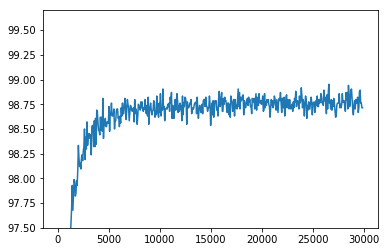

In [36]:
plt.plot(iteration_list,accuracy_list)
plt.ylim(97.5,99.7)
avgSec(accuracy_list)

In [27]:
len(train_loader)
len(featuresTrain)

33600

In [9]:

#Helper function to calculate the average accuracy of the last training run.
def avgSec(array):
        distance = 60
        print("Epoch, median, std")
        for i in range(0,int(count/2/distance),int(n_iters/4/distance)):
            print(int(num_epochs/3*(i/int(n_iters/distance/4)+1)), np.median(accuracy_list[i:i+n_iters]),np.std(accuracy_list[i:i+n_iters]))
            
#avgSec(accuracy_list)


In [ ]:

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(batch_size,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        count += 1
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(batch_size,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if (count) % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count+1, loss.item(), accuracy))